___

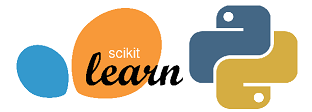
___
# Regresión logística con Python

Para esta clase, trabajaremos con el [Conjunto de datos Titanic desde Kaggle](https://www.kaggle.com/c/titanic). Este es un conjunto de datos muy famoso y muy a menudo es el primer paso de un estudiante en el aprendizaje automático.

Intentaremos predecir una clasificación: supervivencia o fallecimiento.
Comencemos nuestra comprensión de la implementación de la regresión logística en Python para la clasificación.

Usaremos una versión "semi-limpia" del conjunto de datos del Titanic. Si usas el conjunto de datos alojado directamente en Kaggle, es posible que debas hacer una limpieza adicional que no se muestra en esta clase.


## Importar Librerias
¡Vamos a importar algunas bibliotecas para empezar!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn import metrics
%matplotlib inline

## Los Datos

Comencemos leyendo el archivo titanic_train.csv en un dataframe de pandas.

In [2]:
path_file = r'C:/UPC/'

In [3]:
df = pd.read_csv('titanic_train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Estructura de los datos
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
# Cantidad de los datos
df.shape

(891, 12)

In [7]:
## Validamos el número de clientes únicos en la base
len(df.PassengerId.unique())

891

In [8]:
# Guardamos los identificadores de cliente y los excluimos del análisis de variables
df_index = df[['PassengerId','Survived']]
df = df.drop(['PassengerId'], axis = 1)

# Análisis exploratorio de datos

¡Comencemos con un análisis de datos exploratorio! ¡Comenzaremos revisando los datos que faltan!

## Datos faltantes

¡Podemos usar seaborn para crear un mapa de calor simple para ver dónde faltan datos!

<Axes: >

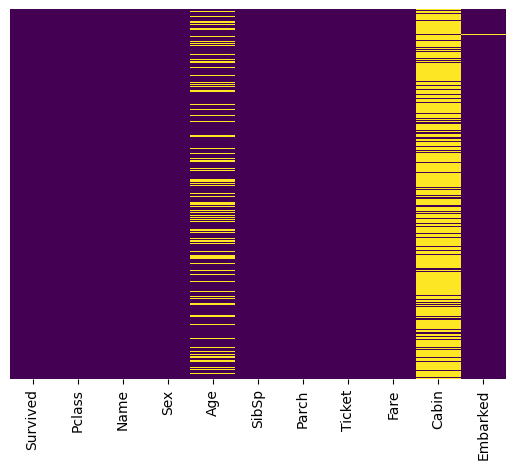

In [9]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
# Número de datos ausentes por variable
# ==============================================================================
df.isna().sum().sort_values()

Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Age         177
Cabin       687
dtype: int64

Falta aproximadamente el 20 por ciento de los datos de Edad. La proporción de edad que falta es probablemente lo suficientemente pequeña como para reemplazarla razonablemente con alguna forma de imputación. Mirando la columna Cabina, parece que simplemente nos faltan demasiados datos para hacer algo útil en un nivel básico. Probablemente eliminaremos esto más tarde o lo cambiaremos a otra función como "Cabina conocida: 1 o 0".

¡Continuemos visualizando algunos datos más!

<Axes: xlabel='Survived', ylabel='count'>

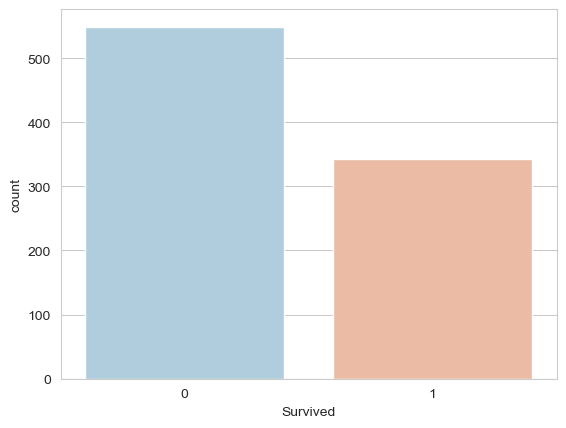

In [11]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=df,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

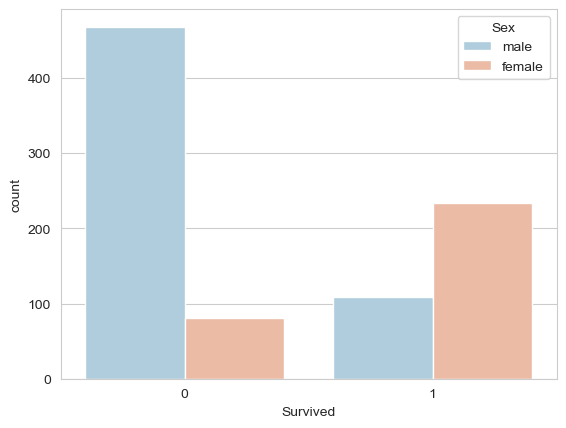

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=df,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

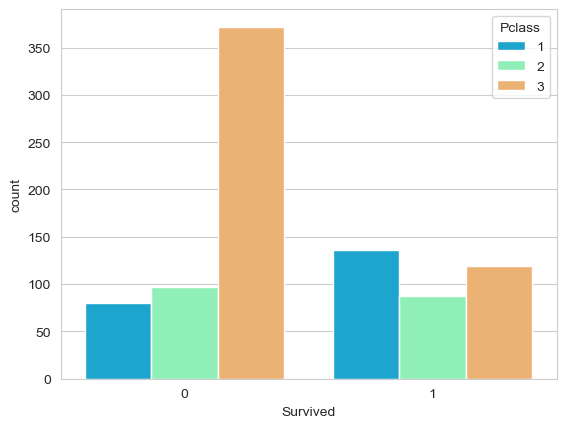

In [13]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=df,palette='rainbow')

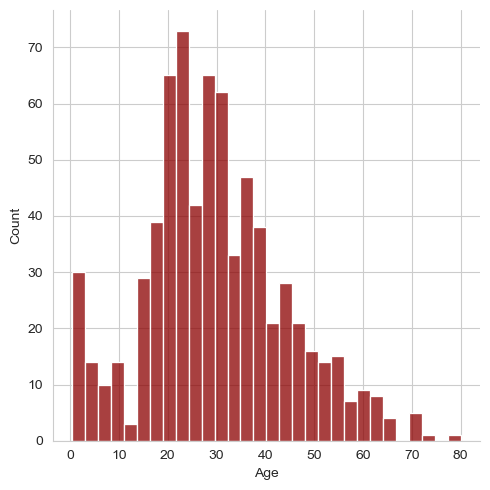

In [14]:
sns.displot(df['Age'].dropna(),kde=False,color='darkred',bins=30)

<Axes: >

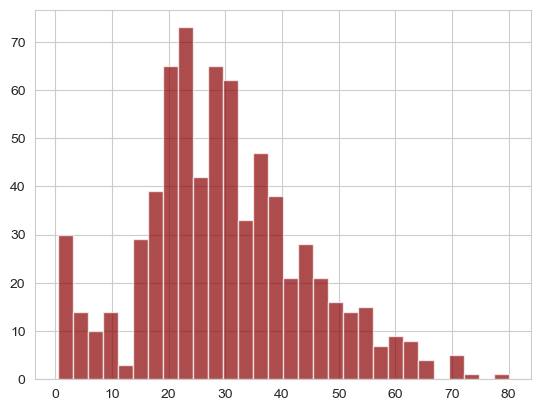

In [15]:
df['Age'].hist(bins=30,color='darkred',alpha=0.7)

<Axes: xlabel='SibSp', ylabel='count'>

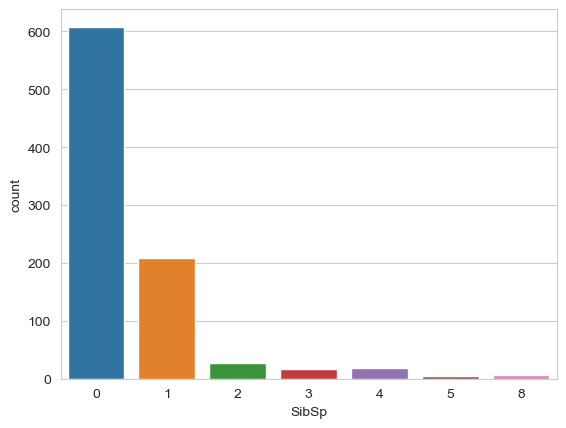

In [16]:
# Número de hermanos/cónyuge a bordo
sns.countplot(x='SibSp',data=df)

<Axes: >

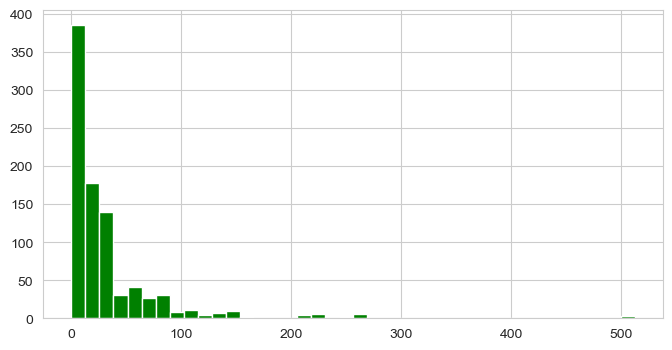

In [17]:
# Tarifa de pasajero
df['Fare'].hist(color='green',bins=40,figsize=(8,4))

____
### Utilizamos el módulo Cufflinks para graficar
___
 ¡Tomemos un momento para mostrar un ejemplo de cufflinks!

In [18]:
import cufflinks as cf
cf.go_offline()

ModuleNotFoundError: No module named 'cufflinks'

In [19]:
df['Fare'].iplot(kind='hist',bins=30,color='green')

#### Variables Numéricas

In [19]:
## Calcula los porcentajes de missings por variable

def fx_porc_missings(data, only_missings = False):

    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings) 

In [20]:
numericas= df.select_dtypes(include=['float64', 'int'])

In [21]:
# Variables numéricas
# ==============================================================================
# df.select_dtypes(include=['float64', 'int']).describe()
numericas.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [22]:
## Missing de Variables
variables_perdidos = fx_porc_missings(numericas, only_missings = True)    
#variables_perdidos.head()
variables_perdidos

,n_nulos,%Total
Age,177,19.86532


___
## Limpiando los datos
Queremos completar los datos de edad que faltan en lugar de simplemente eliminar las filas de datos de edad que faltan. Una forma de hacerlo es completando la edad media de todos los pasajeros (imputación).
Sin embargo, podemos ser más inteligentes al respecto y verificar la edad promedio por clase de pasajero. Por ejemplo:


<Axes: xlabel='Pclass', ylabel='Age'>

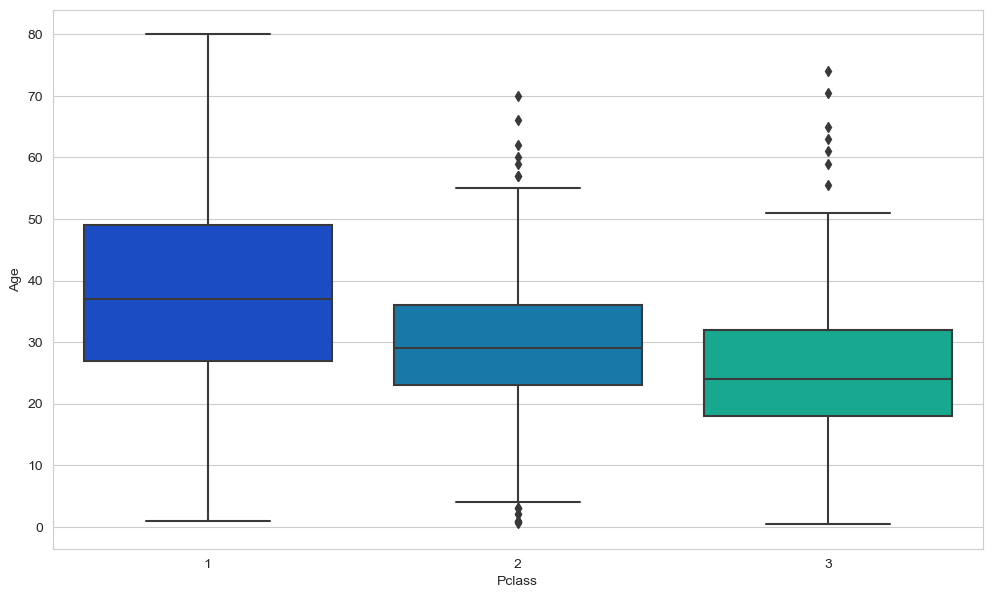

In [23]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=df,palette='winter')

In [24]:
df.groupby('Pclass')[['Age']].mean()

,Age
Pclass,
1,38.233441
2,29.877630
3,25.140620


Podemos ver que los pasajeros más ricos de las clases más altas tienden a ser mayores, lo cual tiene sentido. Usaremos estos valores de edad promedio para imputar según Pclass por Edad.

In [25]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 38

        elif Pclass == 2:
            return 30

        else:
            return 25

    else:
        return Age

¡Ahora apliquemos esta función!

In [26]:
df['Age'] = df[['Age','Pclass']].apply(impute_age,axis=1)

¡Ahora revisemos ese mapa de calor nuevamente!

<Axes: >

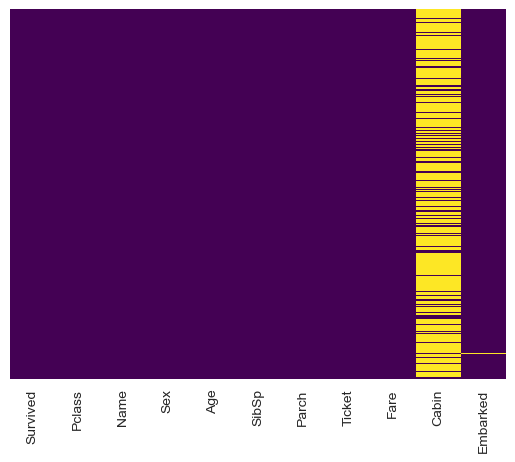

In [27]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Variables Cualitativas

¡Bien! Sigamos adelante y eliminemos las columnas Cabina (Cabin), Name y Ticket mientras Embarcado (Embarked) será imputado.

In [28]:
categoricas = df.select_dtypes(include=['object','category'])

In [29]:
# Variables cualitativas (tipo object)
# ==============================================================================
categoricas.describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [30]:
## Missing de Variables
variables_perdidos = fx_porc_missings(categoricas, only_missings = True)    
#variables_perdidos.head()
variables_perdidos

,n_nulos,%Total
Cabin,687,77.104377
Embarked,2,0.224467


In [31]:
df.Embarked.sort_values().unique()

array(['C', 'Q', 'S', nan], dtype=object)

In [32]:
#Imputar variables
for column in categoricas:
    df[column] = df[column].fillna(df[column].mode()[0]) 

In [33]:
df.drop(['Name','Ticket','Cabin'], axis = 1,inplace=True)

In [34]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [35]:
df.dropna(inplace=True)

### Modelado

Definimos las variables independientes y dependiente

In [36]:
X = df.drop(['Survived'], axis = 1)

In [37]:
y= df.Survived

In [38]:
categoricas = X.select_dtypes(include=('object','category')).columns.tolist()
numericas = X.select_dtypes(include=('int64','float64')).columns.tolist()

## Conversión de características categóricas

¡Necesitaremos convertir características categóricas en variables ficticias usando pandas! De lo contrario, nuestro algoritmo de aprendizaje automático no podrá tomar directamente esas características como entradas.

In [39]:
## Cantidad de Categorías por Variable
variables_str  = X.select_dtypes(include = ['object','category']).columns.tolist()
for var in variables_str:
    print('N de ', var,':',df[var].nunique())

N de  Sex : 2
N de  Embarked : 3


In [40]:
categorical=pd.get_dummies(X[categoricas],columns=categoricas,drop_first=True)
categorical.columns = ['Sex','Embarked_1','Embarked_2']
categorical.head()

,Sex,Embarked_1,Embarked_2
0,1,0,1
1,0,0,0
2,0,0,1
3,0,0,1
4,1,0,1


### Conversión de variables numéricas

In [41]:
numericas

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [42]:
scaler = StandardScaler()
numerical = X[numericas]
numerical = pd.DataFrame(scaler.fit_transform(numerical),
                         columns=['Pclass','Age','SibSp','Parch','Fare'],index= numerical.index)

In [43]:
preprocessed_data = pd.merge(numerical, categorical, left_index=True, right_index=True)
preprocessed_data.head()

,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked_1,Embarked_2
0,0.827377,-0.550185,0.432793,-0.473674,-0.502445,1,0,1
1,-1.566107,0.661499,0.432793,-0.473674,0.786845,0,0,0
2,0.827377,-0.247264,-0.474545,-0.473674,-0.488854,0,0,1
3,-1.566107,0.434308,0.432793,-0.473674,0.420730,0,0,1
4,0.827377,0.434308,-0.474545,-0.473674,-0.486337,1,0,1


¡Bien! ¡Nuestros datos están listos para nuestro modelo!

# Construyendo un modelo de regresión logística

Comencemos por dividir nuestros datos en un conjunto de entrenamiento y un conjunto de prueba (hay otro archivo test.csv con el que puede probar en caso de que quiera usar todos estos datos para el entrenamiento).

## Dividir dataset en Entrenamiento(Train) y Prueba(Test)

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data,y,train_size = 0.7,random_state = 20,stratify = y)

## Entrenamiento y predicción

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
# Se utiliza el paraametro solver (Algoritmo a utilizar en el problema de optimización) y 
# max_iter (Número máximo de iteraciones requeridos para que el solver o algoritmo logre un resultado)
# Documentacion: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

logmodel = LogisticRegression(solver='lbfgs', max_iter=1000) #Parametros utilizados para problemas con multiclases

In [48]:
# Entrenamiento del modelo
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [49]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=logmodel.predict(X_train) # Prediccion sobre el train
y_pred_test=logmodel.predict(X_test) # Prediccion sobre el test

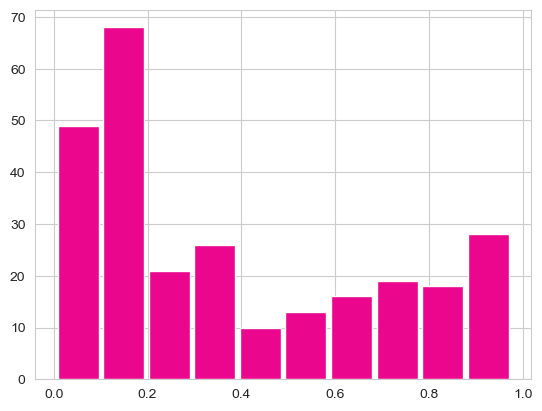

In [50]:
# Calculando probabilidades para la muestra testdel modelo
prob_test_rl = logmodel.predict_proba(X_test)[:,1]
plt.hist(prob_test_rl, color = '#ea068d', rwidth=0.9)
plt.savefig('Probabilidades_logreg.png', bbox_inches='tight')

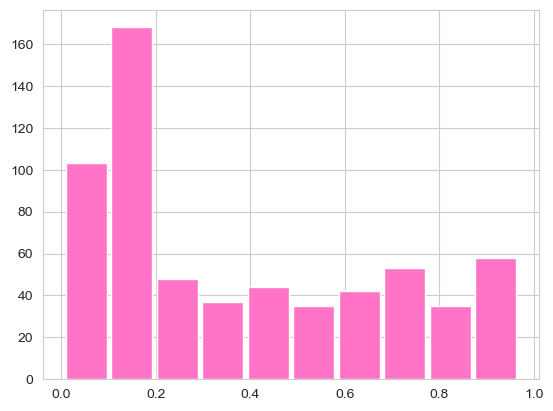

In [51]:
# Calculando las probabilidades para la muestra de entrenamiento
prob_train_rl = logmodel.predict_proba(X_train)[:,1]
plt.hist(prob_train_rl, color = '#ff74c6', rwidth=0.9)
plt.savefig('Probabilidades_train_logreg.png', bbox_inches='tight')

¡Pasemos a evaluar nuestro modelo!

## Evaluación

¡Podemos verificar la precisión, el recall y f1-score utilizando el reporte de clasificación!

In [52]:
from sklearn.metrics import classification_report

In [53]:
predictions = logmodel.predict(X_test)

In [54]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       165
           1       0.81      0.74      0.77       103

    accuracy                           0.83       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268



Otra Forma

In [55]:
## Funciones
def print_mc(matriz_conf):
    matriz_conf = pd.DataFrame(matriz_conf)
    matriz_conf.index = ["Real_0","Real_1"]
    matriz_conf.columns = ["Pred_0","Pred_1"]
    print(matriz_conf)
    
def fx_evaluate_classif(y_real, pred, pred_proba):
    from sklearn import metrics as mt
    matriz_conf = mt.confusion_matrix(y_real,pred)
    print_mc(matriz_conf)
    roc = mt.roc_auc_score(y_real,pred_proba)
    accuracy_real = mt.accuracy_score(y_real,pred)
    print("\nROC: ", roc) 
    print("Accu:", accuracy_real,'\n')
    print(mt.classification_report(y_real, pred)[0:163])

In [56]:
print("Metricas del Testing..." + "\n")
fx_evaluate_classif(y_test, y_pred_test, prob_test_rl)

Metricas del Testing...

        Pred_0  Pred_1
Real_0     147      18
Real_1      27      76

ROC:  0.8601353339217418
Accu: 0.832089552238806 

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       165
           1       0.81      0.74      0.77       103



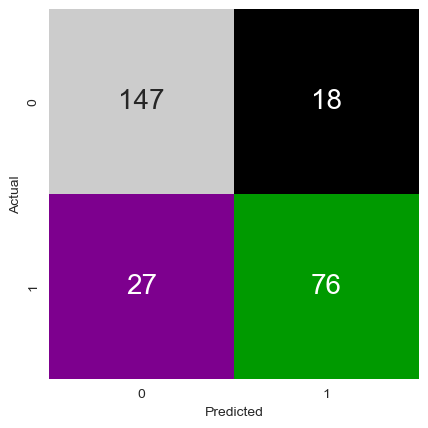

In [57]:
mat_logreg = confusion_matrix(y_test, y_pred_test)
sns.heatmap(mat_logreg, annot=True, fmt='d',cmap='nipy_spectral', square=True, cbar=False, annot_kws = {'size' : 20})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion_matrix_logreg.png', bbox_inches='tight')

**Precision** es la proporción de predicciones de esa clase que son verdaderas. Entonces, el 79% de las predicciones son verdaderas para la clase 0 predicha (fallecio) y 71% de las predicciones son verdaderas para la clase 1 predicha (sobrevivio)

**Recall** es la proporción de verdaderos positivos que se identifican como tales. Esto significa que su modelo está identificando correctamente el 81% de la clase 0, pero solo el 69% de la clase 1.

**F1-score** solo es útil si Precision y Recall son similares.

**support** El soporte es el número de apariciones reales de la clase en el conjunto de datos especificado, es decir, el número de muestras con la respuesta verdadera que se encuentran en esa clase. 

#### Curva ROC

In [58]:
## AUC: Area bajo la curva
auc_rl = metrics.roc_auc_score(y_test, prob_test_rl)
auc_rl

0.8601353339217418

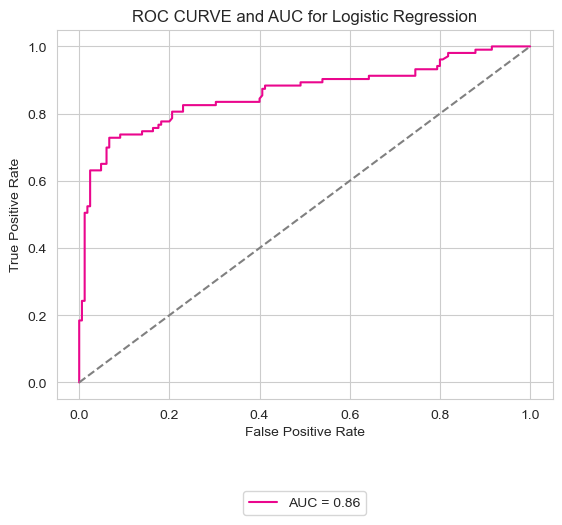

In [59]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_test_rl)
plt.plot(fpr, tpr, label= "AUC = " + str(auc_rl.round(3)), color='#ea068d')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC CURVE and AUC for Logistic Regression')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(.5,-0.23), loc='upper center')
plt.savefig('ROC_CURVES_logreg.png', bbox_inches='tight')

### Resultados del Modelo

In [60]:
# Asignamos las probabilidades a los datos transformados
probabilidad = list(prob_test_rl.round(3))
probabilidad_train = list(prob_train_rl.round(3))
X_test['PROBABILIDAD'] = probabilidad
X_train['PROBABILIDAD'] = probabilidad_train

In [61]:
# Ordenamos de mayor a menor las probabilidades
X_train = X_train.sort_values(['PROBABILIDAD'], ascending=False)
X_test = X_test.sort_values(['PROBABILIDAD'], ascending=False)

In [62]:
# Creamos grupos de probabilidad para la muestra de entrenamiento
X_train['GRUPOS'] = pd.qcut(X_train['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [63]:
# Creamos grupos de probabilidad para la muestra de validación
X_test['GRUPOS'] = pd.qcut(X_test['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [64]:
# Añadimos los identificadores de clientes
final_train = X_train.merge(df_index, how='left', left_index=True, right_index=True, sort=False)
final_test = X_test.merge(df_index, how='left', left_index=True, right_index=True, sort=False)

In [65]:
final_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked_1,Embarked_2,PROBABILIDAD,GRUPOS,PassengerId,Survived
297,-1.566107,-2.064789,0.432793,2.008933,2.402990,0,0,1,0.968,1,298,0
310,-1.566107,-0.398724,-0.474545,-0.473674,1.025945,0,0,0,0.967,1,311,1
369,-1.566107,-0.398724,-0.474545,-0.473674,0.746912,0,0,0,0.966,1,370,1
641,-1.566107,-0.398724,-0.474545,-0.473674,0.746912,0,0,0,0.966,1,642,1
689,-1.566107,-1.080296,-0.474545,0.767630,3.606793,0,0,1,0.966,1,690,1


In [66]:
# Creamos una tabla resumen para la muestra de entrenamiento, donde debe mostrarse:
# - La distribución por grupos del modelo
# - La probabilidad mínima, media y máxima de cada grupo
# - Comparamos con la respuesta real de la muestra
resumen_train = final_train.groupby('GRUPOS')['PROBABILIDAD'].agg(['count','min','max','mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
ventas_train = final_train.groupby('GRUPOS')['Survived'].agg(['sum', 'min', 'max', 'mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
resumen_train = pd.merge(resumen_train, ventas_train[['sum','mean']], left_index=True, right_index=True)
resumen_train.rename(columns={'count' : 'Leads', 'min' : 'Min', 'max': 'Max', 'sum': 'Préstamo', 'mean_x' : '%RR (Estimado)', 'mean_y' : '%RR (Real)'}, inplace = True)
resumen_train.to_excel(path_file + '\Resultados_train_RegLog.xlsx', index = False)
resumen_train

,GRUPOS,Leads,Min,Max,%RR (Estimado),Préstamo,%RR (Real)
9,1,63,0.866,0.968,0.916603,62,0.984127
8,2,62,0.701,0.863,0.775113,48,0.774194
7,3,62,0.592,0.700,0.650129,45,0.725806
6,4,62,0.446,0.583,0.507710,23,0.370968
5,5,62,0.288,0.438,0.358226,20,0.322581
4,6,59,0.157,0.284,0.225508,13,0.220339
3,7,66,0.131,0.156,0.146000,8,0.121212
2,8,37,0.112,0.130,0.121459,4,0.108108
1,9,83,0.077,0.110,0.099627,12,0.144578
0,10,67,0.004,0.075,0.052463,4,0.059701


In [67]:
# Creamos una tabla resumen para la muestra de validación, donde debe mostrarse:
# - La distribución por grupos del modelo
# - La probabilidad mínima, media y máxima de cada grupo
# - Comparamos con la respuesta real de la muestra
resumen_test = final_test.groupby('GRUPOS')['PROBABILIDAD'].agg(['count','min','max','mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
ventas_test = final_test.groupby('GRUPOS')['Survived'].agg(['sum', 'min', 'max', 'mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
resumen_test = pd.merge(resumen_test, ventas_test[['sum','mean']], left_index=True, right_index=True)
resumen_test.rename(columns={'count' : 'Leads', 'min' : 'Min', 'max': 'Max', 'sum': 'Préstamo', 'mean_x' : '%RR (Estimado)', 'mean_y' : '%RR (Real)'}, inplace = True)
resumen_test.to_excel(path_file + '\Resultados_test_RegLog.xlsx', index = False)
resumen_test

,GRUPOS,Leads,Min,Max,%RR (Estimado),Préstamo,%RR (Real)
9,1,27,0.905,0.975,0.939741,25,0.925926
8,2,27,0.765,0.896,0.815481,27,1.000000
7,3,27,0.589,0.746,0.660852,19,0.703704
6,4,26,0.384,0.583,0.491423,7,0.269231
5,5,27,0.273,0.372,0.329593,7,0.259259
4,6,27,0.161,0.264,0.219296,6,0.222222
3,7,24,0.126,0.156,0.144833,2,0.083333
2,8,28,0.110,0.123,0.114750,1,0.035714
1,9,27,0.074,0.107,0.091407,7,0.259259
0,10,28,0.004,0.072,0.047036,2,0.071429


## Buen Trabajo!